In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from pandas.plotting import scatter_matrix
import seaborn as sns
import pylab as plb
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

%matplotlib inline

In [ ]:
# Verover data en bekijk het
path = "/content/drive/My Drive/minor/DL/bee_wasp/"
df = pd.read_csv(path + 'labels.csv', sep =",")
df = df.sample(n=2000)
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
4340,4341,wasp1\39517033_59cd6f5b12_n.jpg,0,1,0,0,1,0,0,wasp
8224,8225,other_insect\14177812438_d146a70a77_w.jpg,0,0,1,0,1,0,0,insect
3463,3464,wasp1\16508538591_91a453b815_n.jpg,0,1,0,0,1,0,0,wasp
6128,6129,wasp2\G00177.jpg,0,1,0,0,0,0,0,wasp
1734,1735,bee1\5606099976_4e6bdf8a90_n.jpg,1,0,0,0,1,0,0,bee


In [ ]:
df.shape

(2000, 10)

De kolom id is niet nodig aangezien er al een id is gegeven en de \ in de path's moet worden veranderd naar /.

In [ ]:
# Verander de backslash
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

100%|██████████| 2000/2000 [00:00<00:00, 2217.88it/s]


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
4340,4341,wasp1/39517033_59cd6f5b12_n.jpg,0,1,0,0,1,0,0,wasp
8224,8225,other_insect/14177812438_d146a70a77_w.jpg,0,0,1,0,1,0,0,insect
3463,3464,wasp1/16508538591_91a453b815_n.jpg,0,1,0,0,1,0,0,wasp
6128,6129,wasp2/G00177.jpg,0,1,0,0,0,0,0,wasp
1734,1735,bee1/5606099976_4e6bdf8a90_n.jpg,1,0,0,0,1,0,0,bee


In [ ]:
# Kijk of er null-waarden zijn
df.isnull().sum()

id                     0
path                   0
is_bee                 0
is_wasp                0
is_otherinsect         0
is_other               0
photo_quality          0
is_validation          0
is_final_validation    0
label                  0
dtype: int64

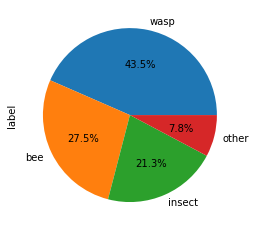

In [ ]:
df.label.value_counts().plot.pie(autopct='%1.1f%%')


In [ ]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    if row['is_validation'] == 1:
        return 'validation'
    return 'test'

df['type'] = df.apply(set_train_type, axis=1)
print('Number values of each type')
df['type'].value_counts()


Number values of each type


train         1420
validation     302
test           278
Name: type, dtype: int64

In [ ]:
import cv2

def display_img(row, pos):
    #Because path use back slash
    fn = row['path']
    fn = path + fn
    #Read image from path
    img = cv2.imread(fn)
    #Resize all images with the same size
    img = cv2.resize(img, (128, 128))
    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title(row['label'])
    #Remove ticks
    plt.xticks([])
    plt.yticks([])


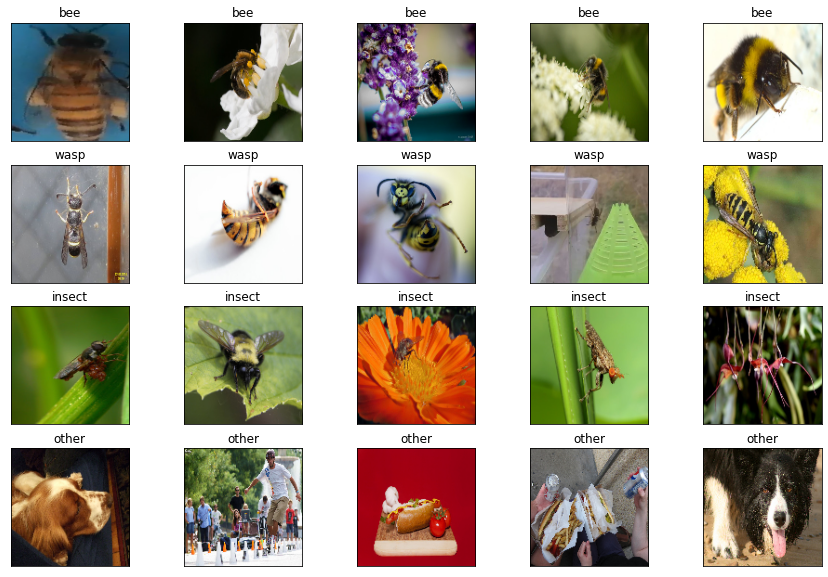

In [ ]:
bee = df[df["label"] == 'bee'].sample(5, random_state=42)
wasp = df[df["label"] == 'wasp'].sample(5, random_state=42)
insect = df[df["label"] == 'insect'].sample(5, random_state=42)
other = df[df["label"] == 'other'].sample(5, random_state=42)

plt.figure(figsize=(15,10))
pos = 1
# Display bee
for idx, row in bee.iterrows():
    display_img(row, pos)
    pos += 1
# Display wasp    
for idx, row in wasp.iterrows():
    display_img(row, pos)
    pos += 1
# Display other insects
for idx, row in insect.iterrows():
    display_img(row, pos)
    pos += 1
# Display others
for idx, row in other.iterrows():
    display_img(row, pos)
    pos += 1
    
plt.show()

In [ ]:
train_wasp = sorted((path +'/wasp1'))
train_bee =  sorted((path +'/bee1'))


test_wasp = sorted((path +'/wasp2'))
test_bee =  sorted((path +'/bee2'))

list=["train_wasp","train_bee","test_wasp","test_bee"]

In [ ]:
train_df = df[df['type'] == 'train']
valid_df = df[df['type'] == 'validation']
test_df = df[df['type'] == 'test']

In [ ]:
TARGET_SIZE = (256, 256)
SEED = 42

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)


train_datagen = datagen.flow_from_dataframe(train_df, 
                                            directory=path, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

valid_datagen = datagen.flow_from_dataframe(valid_df,
                                            directory=path, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

test_datagen = datagen.flow_from_dataframe(test_df, 
                                           directory=path, 
                                           x_col='path', 
                                           y_col='label',
                                           target_size=TARGET_SIZE,
                                           seed=42
                                           ) 

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [ ]:
n_class = len(df['label'].unique())


In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001), input_shape=(256,256,3)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),    
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 2
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 3
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 4
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # Block 5
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Dense(n_class, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.1),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=500,
          epochs=2,
         )

In [ ]:
def show_loss_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.show()

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, input_shape=(256, 256, 3))

In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(n_class, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=32,
          epochs=50,
         )

In [ ]:
show_loss_acc(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)